In [1]:
import pandas as pd
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import pickle
from datetime import datetime, timedelta

Get TSD data:

In [21]:
TSD_Snorre = pd.read_csv('snorre_19H-QI___5472_10min_(4480).csv')

Get currents data:

In [22]:
currents_snorre = pd.read_csv('Currents_Snorre_April_2021.csv')

In [23]:
currents_snorre['Time'] = pd.to_datetime(currents_snorre['Timestamp'])

In [24]:
currents_snorre

,YY,MM,DD,Min,CD317,CS317,HH,Timestamp,Time
0,2021,4,5,0,105.4,7.3,14,2021-04-05 14:00:00,2021-04-05 14:00:00
1,2021,4,5,10,107.1,6.7,14,2021-04-05 14:10:00,2021-04-05 14:10:00
2,2021,4,5,20,104.7,6.1,14,2021-04-05 14:20:00,2021-04-05 14:20:00
3,2021,4,5,30,101.2,6.7,14,2021-04-05 14:30:00,2021-04-05 14:30:00
4,2021,4,5,40,102.6,6.4,14,2021-04-05 14:40:00,2021-04-05 14:40:00
...,...,...,...,...,...,...,...,...,...
4610,2021,5,7,20,92.8,8.6,14,2021-05-07 14:20:00,2021-05-07 14:20:00
4611,2021,5,7,30,96.0,8.0,14,2021-05-07 14:30:00,2021-05-07 14:30:00
4612,2021,5,7,40,95.6,8.3,14,2021-05-07 14:40:00,2021-05-07 14:40:00
4613,2021,5,7,50,95.3,8.6,14,2021-05-07 14:50:00,2021-05-07 14:50:00


In [25]:
currents_snorre.describe()

,YY,MM,DD,Min,CD317,CS317,HH
count,4615.0,4615.000000,4615.000000,4615.000000,4615.000000,4615.000000,4615.000000
mean,2021.0,4.206934,14.899458,24.994583,140.841582,10.277876,11.504009
std,0.0,0.405152,8.686633,17.082216,75.830470,5.831957,6.918462
min,2021.0,4.000000,1.000000,0.000000,0.000000,1.100000,0.000000
25%,2021.0,4.000000,7.000000,10.000000,93.500000,6.100000,6.000000
50%,2021.0,4.000000,14.000000,20.000000,127.700000,10.500000,12.000000
75%,2021.0,4.000000,22.000000,40.000000,169.600000,14.500000,17.000000
max,2021.0,5.000000,30.000000,50.000000,359.600000,27.000000,23.000000


In [26]:
currents_snorre['Timestamp']

0       2021-04-05 14:00:00
1       2021-04-05 14:10:00
2       2021-04-05 14:20:00
3       2021-04-05 14:30:00
4       2021-04-05 14:40:00
               ...         
4610    2021-05-07 14:20:00
4611    2021-05-07 14:30:00
4612    2021-05-07 14:40:00
4613    2021-05-07 14:50:00
4614    2021-05-07 15:00:00
Name: Timestamp, Length: 4615, dtype: object

In [15]:
##Snorre:

In [16]:
TSD_Snorre['Time'] = pd.to_datetime(TSD_Snorre['Time'])

In [17]:
TSD_Snorre = TSD_Snorre[TSD_Snorre['Values'] <= 10000]

In [18]:
TSD_Snorre['Time']

8      2021-04-05 14:00:00
9      2021-04-05 14:10:00
10     2021-04-05 14:20:00
11     2021-04-05 14:30:00
12     2021-04-05 14:40:00
               ...        
4475   2021-05-07 14:20:00
4476   2021-05-07 14:30:00
4477   2021-05-07 14:40:00
4478   2021-05-07 14:50:00
4479   2021-05-07 15:00:00
Name: Time, Length: 4472, dtype: datetime64[ns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


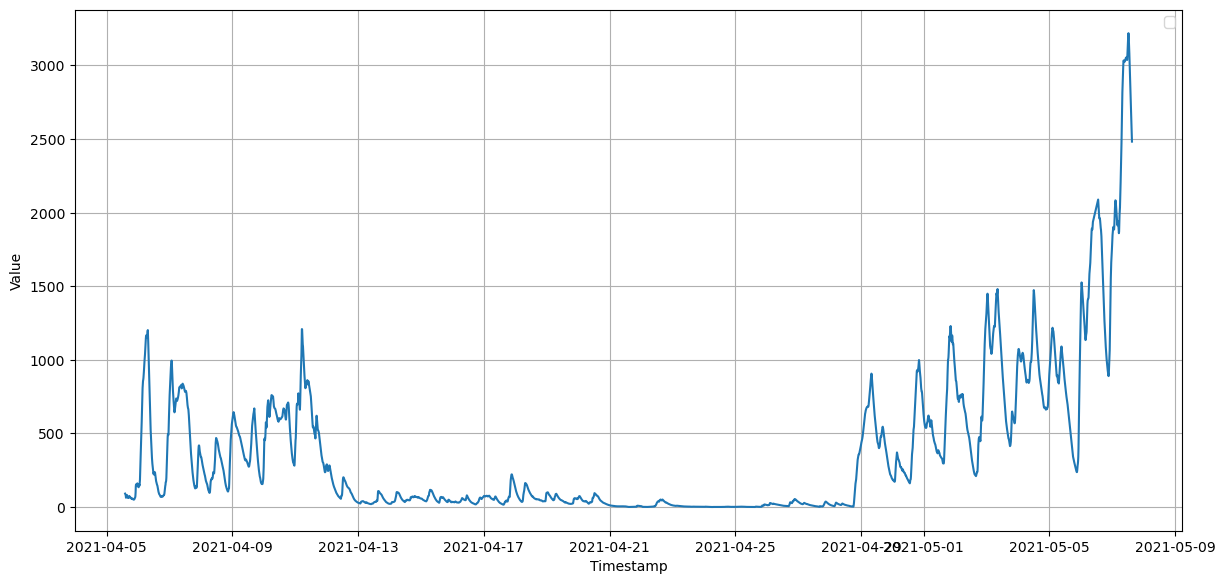

In [19]:
plt.figure(figsize=(12, 6))
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.plot(TSD_Snorre['Time'], TSD_Snorre['Values'])
    

In [20]:
## Anomaly detection and date estimation

In [21]:
df_base = pd.read_csv("trestakk_1TA_10min_(125810).csv",index_col=0)
df_base = df_base.loc[df_base['Values'] < 100000]
df_base = df_base[df_base['Values'] > 0]

In [22]:
from anomaly_detection_with_event_logs import *

In [23]:
start_stop_list = []

In [37]:
tsd_values = TSD_Snorre['Values']

In [38]:
snorre5472 = sensor_stream(df_base.Values.values,144, start_stop_list)

In [39]:
for i in tsd_values.values:
    snorre5472.track_data(i)

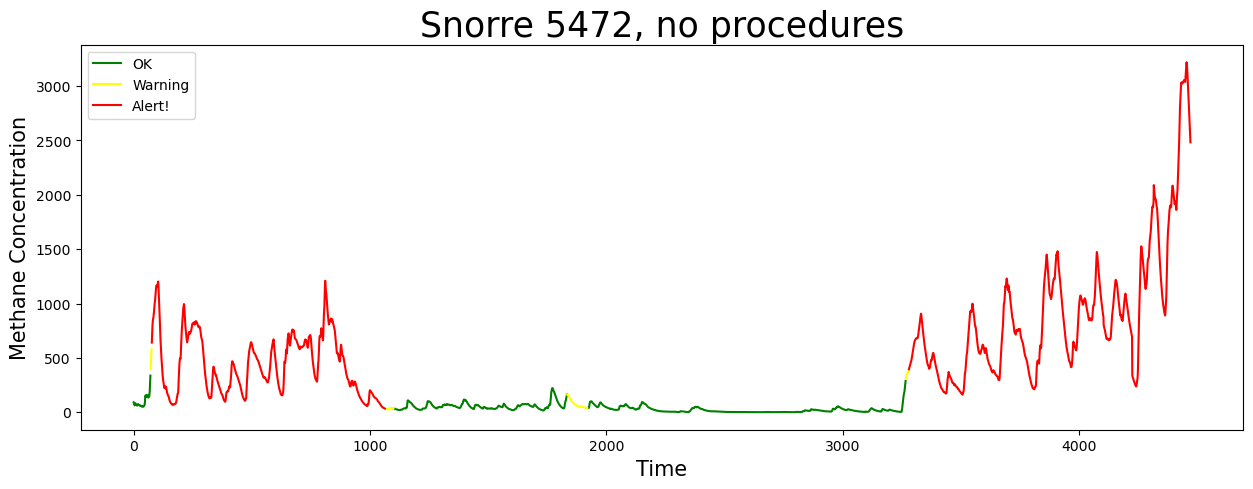

[75, 3274]


In [40]:
anomaly_start_indices = snorre5472.plot(title ="Snorre 5472, no procedures")

In [42]:
snorre5472.event_logs.count(0)

2268

In [43]:
snorre5472.event_logs.count(1)

2204

extract starting dates:

In [44]:
# Extracting datetime objects from DataFrame using indices
time_values = TSD_Snorre.iloc[anomaly_start_indices]['Time'].tolist()

print(time_values)

[Timestamp('2021-04-06 02:30:00'), Timestamp('2021-04-28 22:30:00')]


In [47]:
with open('anomaly_timestamps_Snorre.pkl', 'wb') as file:
    pickle.dump(time_values, file)

In [6]:
with open('anomaly_timestamps_Snorre.pkl', 'rb') as file:
    time_values = pickle.load(file)

Using timestamps extracting current data

In [7]:
start_date = time_values[1] - timedelta(hours=6)
end_date = start_date + timedelta(hours=24)

In [ ]:
# Filter the DataFrame between the start and end dates
TSD_Snorre_April = TSD_Snorre[(TSD_Snorre['Time'] >= start_date) & (TSD_Snorre['Time'] <= end_date)]

currents_snorre_April = currents_snorre[(currents_snorre['Time'] >= start_date) & (currents_snorre['Time'] <= end_date)]

In [29]:
currents_snorre_April_prepared = currents_snorre_April[['CD317','CS317']]

In [30]:
currents_snorre_April_prepared = currents_snorre_April_prepared.rename(columns={'CD317': 'CD', 'CS317': 'CS'})

In [45]:
currents_snorre_April_prepared['CS'] = currents_snorre_April_prepared['CS']*0.01

In [46]:
currents_snorre_April_prepared

,CD,CS
3327,174.5,0.070
3328,174.8,0.077
3329,172.0,0.083
3330,174.5,0.089
3331,178.3,0.086
...,...,...
3467,150.8,0.120
3468,150.8,0.136
3469,153.9,0.139
3470,154.6,0.127


In [47]:
currents_snorre_April_prepared.to_csv('./current_prepared/currents_snorre_April_2.csv')

In [33]:
TSD_Snorre_April.to_csv('./anomaly_data_prepared/TSD_Snorre_April_2.csv')

In [34]:
currents_snorre_April

,YY,MM,DD,Min,CD317,CS317,HH,Timestamp,Time
3327,2021,4,28,30,174.5,7.0,16,2021-04-28 16:30:00,2021-04-28 16:30:00
3328,2021,4,28,40,174.8,7.7,16,2021-04-28 16:40:00,2021-04-28 16:40:00
3329,2021,4,28,50,172.0,8.3,16,2021-04-28 16:50:00,2021-04-28 16:50:00
3330,2021,4,28,0,174.5,8.9,17,2021-04-28 17:00:00,2021-04-28 17:00:00
3331,2021,4,28,10,178.3,8.6,17,2021-04-28 17:10:00,2021-04-28 17:10:00
...,...,...,...,...,...,...,...,...,...
3467,2021,4,29,50,150.8,12.0,15,2021-04-29 15:50:00,2021-04-29 15:50:00
3468,2021,4,29,0,150.8,13.6,16,2021-04-29 16:00:00,2021-04-29 16:00:00
3469,2021,4,29,10,153.9,13.9,16,2021-04-29 16:10:00,2021-04-29 16:10:00
3470,2021,4,29,20,154.6,12.7,16,2021-04-29 16:20:00,2021-04-29 16:20:00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


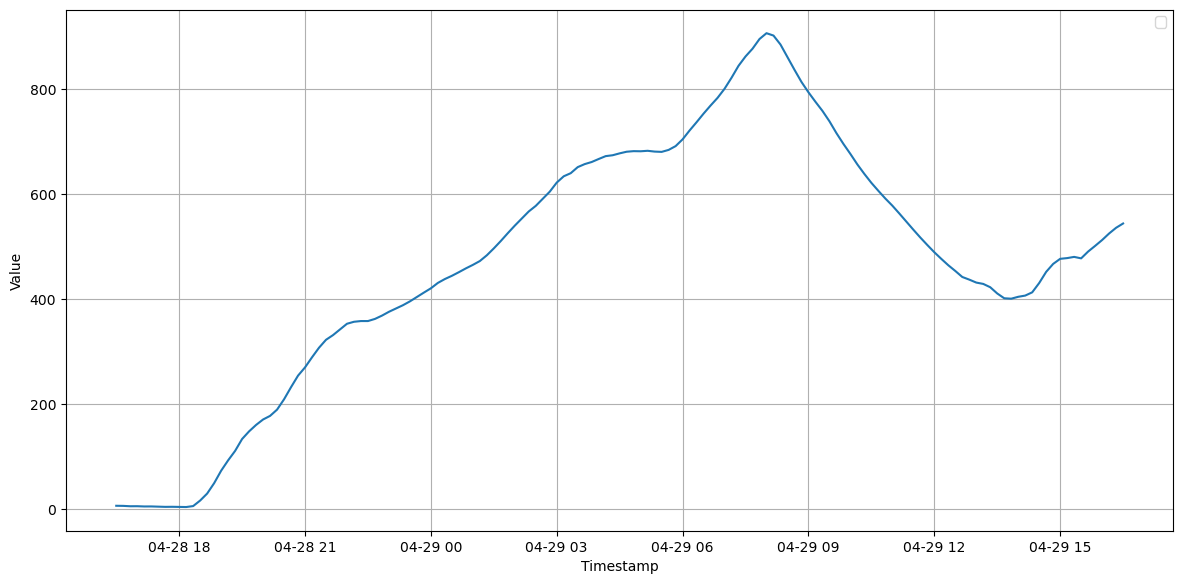

In [85]:
plt.figure(figsize=(12, 6))
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.plot(TSD_Snorre_April['Time'], TSD_Snorre_April['Values'])
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


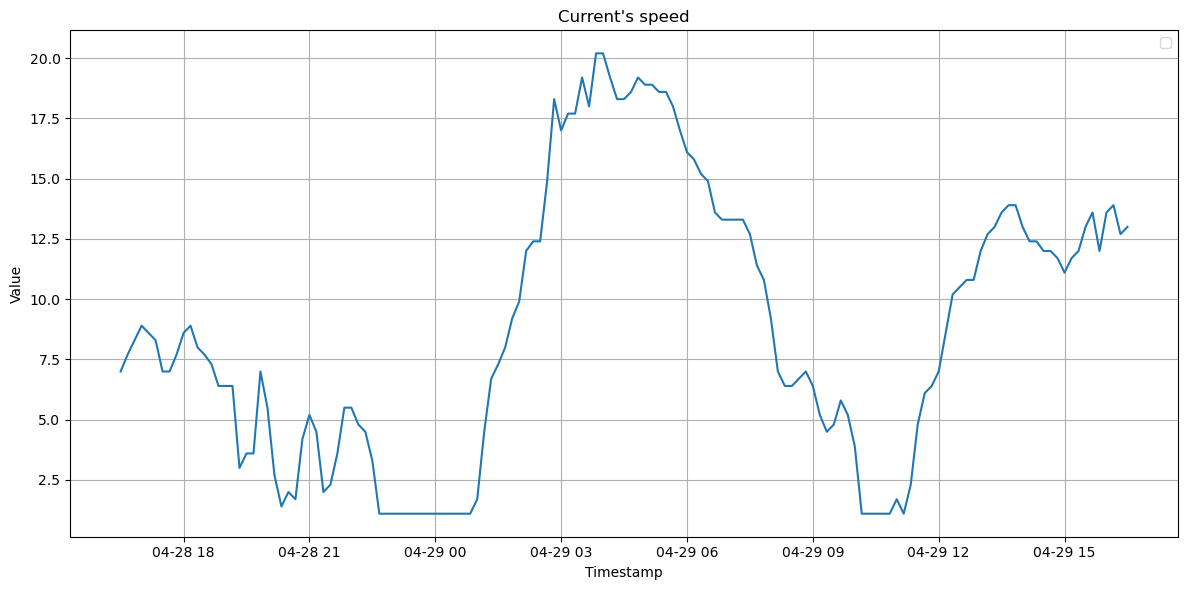

In [88]:
plt.figure(figsize=(12, 6))
plt.legend()
plt.title("Current's speed")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.plot(currents_snorre_April['Time'], currents_snorre_April['CS317'])
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


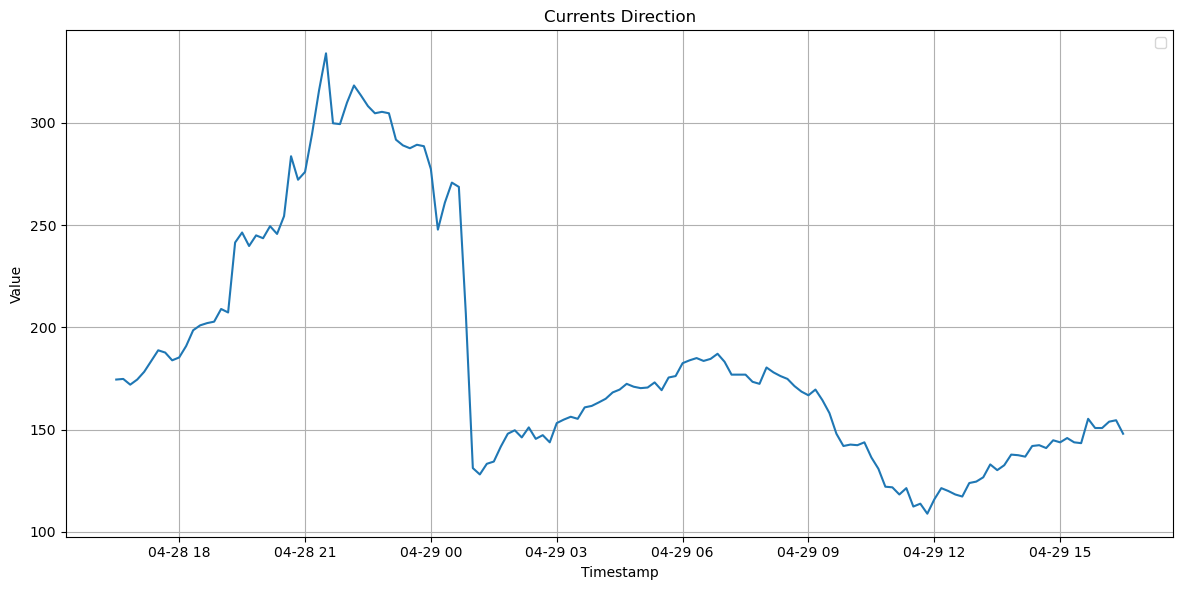

In [89]:
plt.figure(figsize=(12, 6))
plt.legend()
plt.title("Currents Direction")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.plot(currents_snorre_April['Time'], currents_snorre_April['CD317'])

# Simulation results

In [ ]:
#After running the simulation we get following object

In [11]:
with open('./simulation_results/resulting_curves_Snorre_tau120_lc4.3_geomTrue.pkl', 'rb') as file:
    simulation_results = pickle.load(file)

* Compute the cross-correlation between a reference time series and four other time series.
* Identify the lag with the maximum correlation and the correlation score for that lag for each of the four comparisons.
* Plot each time series alongside the reference time series, ordered by the correlation score (highest first).
* Repeat the above steps using dynamic time warping (DTW) and order the plots by normalized DTW distance (lowest first).

In [13]:
def plot_sensor_data(data, tau = 40, leak_coef = 1.0):
    fig, axes = plt.subplots(nrows=len(data), figsize=(10, 15))
    for ax, (sensor, leak_data) in zip(axes, data.items()):
        for leak, y_values in leak_data.items():
            ax.plot(y_values, label=leak)
        ax.set_title(f'{sensor}, leak_coef {leak_coef}, tau {tau}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Concentration')
        ax.legend()
    plt.tight_layout()
    plt.show()
    # Save the figure if a filename is provided
    #if signal:
    #    fig.savefig(f'{path}/plots/results_signal_lc{leak_coef}_geom{geometrical}.png', dpi=300) 
    #else:
    #    fig.savefig(f'{path}/plots/results_response_tau{tau}_lc{leak_coef}_geom{geometrical}.png', dpi=300) 

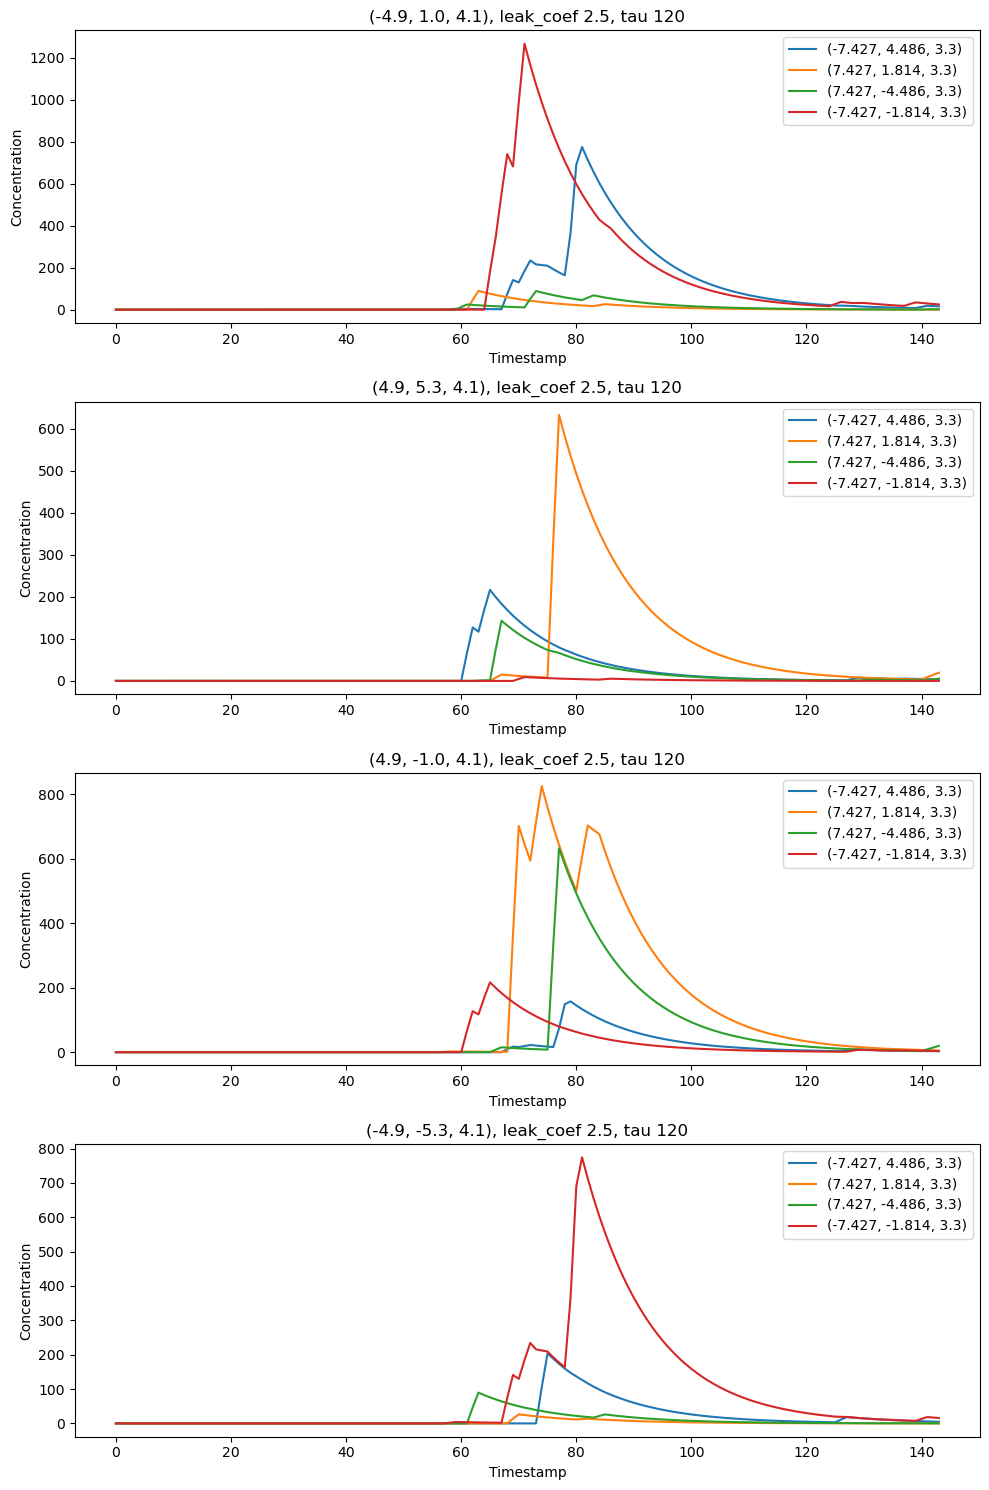

In [14]:
plot_sensor_data(simulation_results, tau = 120, leak_coef = 2.5)

In [18]:
curves = list(simulation_results[(-4.9, -5.3, 4.1)].values())

In [55]:
def max_cross_correlation(reference, series, max_lag=20, beta=0.002):
    correlation = correlate(reference, series, mode="full")
    
    # Limit to lags within the desired range [-max_lag, max_lag]
    valid_range = len(reference) - 1  # The zero lag position
    correlation[:valid_range - max_lag] = 0
    correlation[valid_range + max_lag + 1:] = 0
    
    norm_factor = np.sqrt(np.sum(reference**2) * np.sum(series**2))
    normalized_correlation = correlation / norm_factor
    
    # Apply penalty based on lag value
    lags = np.arange(-valid_range, len(series))
    penalties = 1 + beta * np.abs(lags)
    penalized_correlation = normalized_correlation / penalties
    
    # Ensure the penalized correlation is still within the desired lag range
    penalized_correlation[:valid_range - max_lag] = 0
    penalized_correlation[valid_range + max_lag + 1:] = 0
    
    lag = penalized_correlation.argmax() - valid_range
    return lag, penalized_correlation.max()


def plot_series(reference, series_list, method="correlation"):
    results = []
    for i, series in enumerate(series_list):
        if method == "correlation":
            lag, score = max_cross_correlation(reference, series)
            results.append((series, lag, score, i))
        elif method == "dtw":
            dtw_distance, path = fastdtw(np.reshape(reference, (-1, 1)), np.reshape(series, (-1, 1)), dist=euclidean)
            normalized_dtw = dtw_distance / len(path)
            results.append((series, 0, normalized_dtw, i))
        else:
            raise ValueError("Invalid method specified")

    # Sorting results
    if method == "correlation":
        results.sort(key=lambda x: x[2], reverse=True)
    elif method == "dtw":
        results.sort(key=lambda x: x[2], reverse=False)
    # Plotting
    for series, lag, score, _ in results:
        plt.figure(figsize=(10, 5))
        plt.plot(reference, label="Reference", alpha=0.7)
        plt.plot(np.arange(lag, lag+len(series)), series, label="Series", alpha=0.7)
        if method == "correlation":
            plt.title(f"{method.capitalize()} Score: {score:.2f}, lag: {lag} ")
        else:
            plt.title(f"{method.capitalize()} Score: {score:.2f}, path length: {len(path)}")
        
        plt.legend()
        plt.show()
    return results

In [56]:
TSD_Snorre_April = pd.read_csv('./anomaly_data_prepared/TSD_Snorre_April_2.csv')

In [57]:
reference_series = np.array(TSD_Snorre_April['Values'])
other_series_copy = np.array(curves)

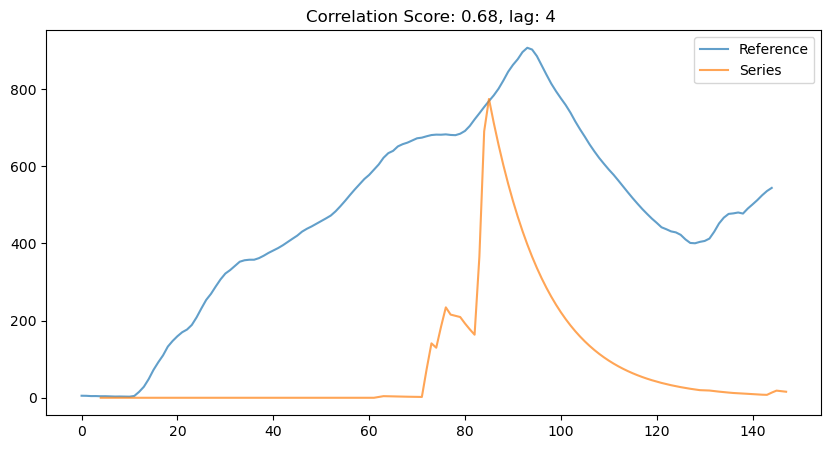

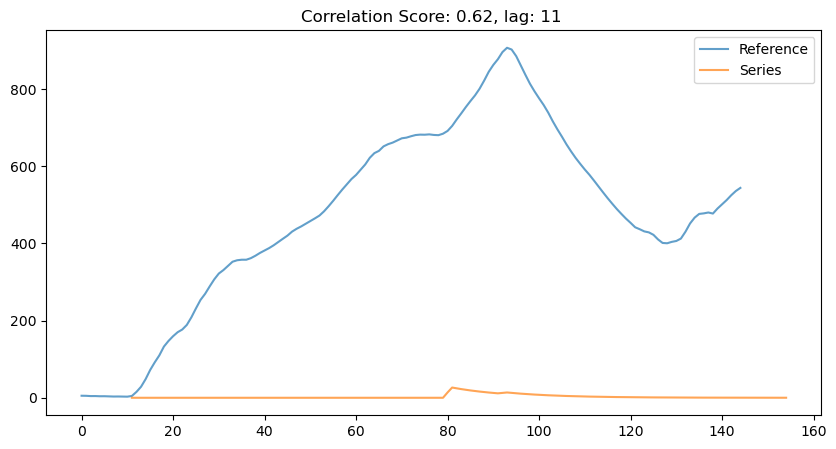

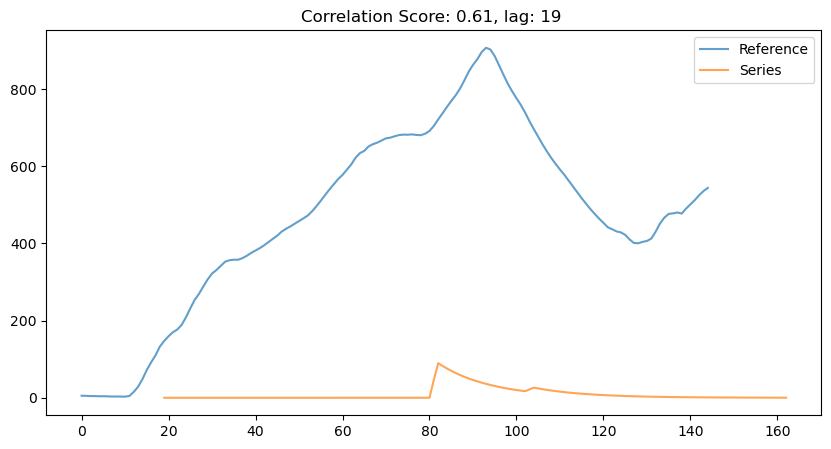

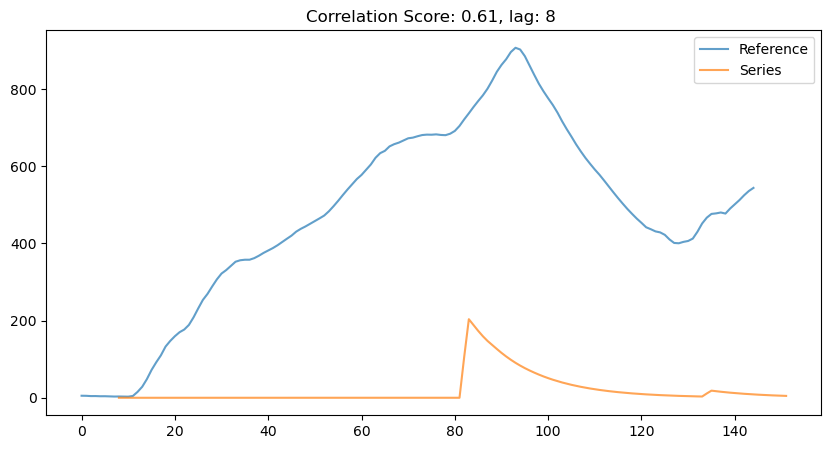

In [98]:
# For Cross-Correlation
results_cor = plot_series(reference_series, other_series_copy, method="correlation")


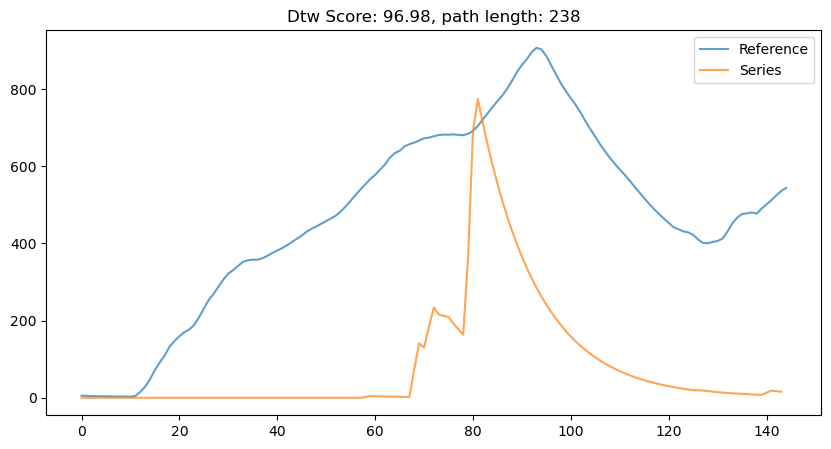

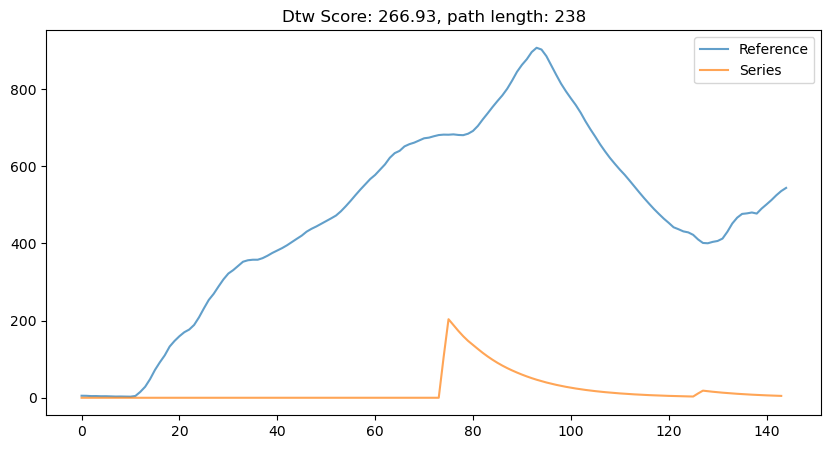

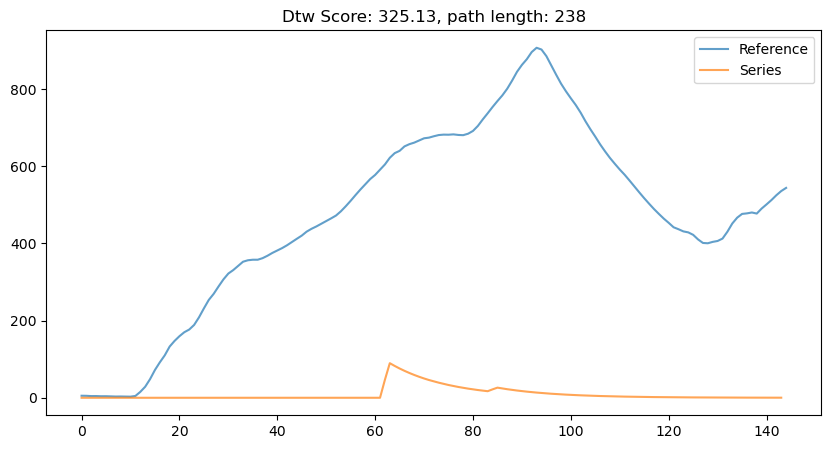

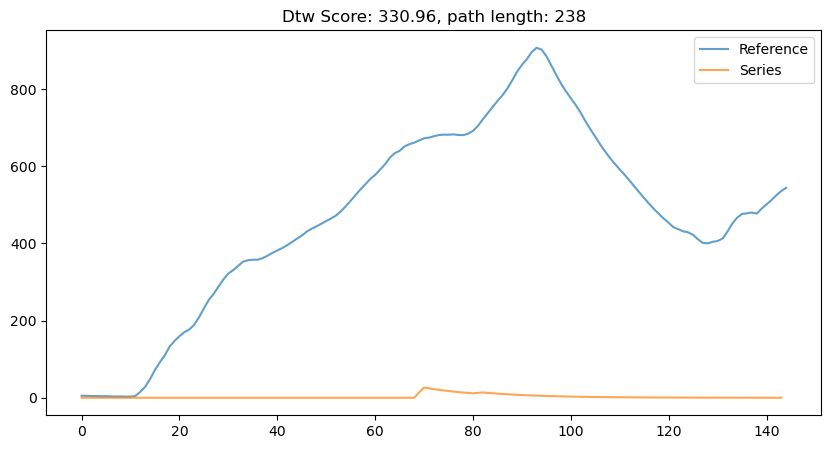

In [99]:
# For DTW
results_dtw = plot_series(reference_series,  other_series_copy, method="dtw")

In [100]:
indices_cor = [i for (_,_,_,i) in results_cor]

In [101]:
indices_dtw = [i for (_,_,_,i) in results_dtw]

In [102]:
indices_cor

[3, 1, 2, 0]

In [103]:
indices_dtw 

[3, 0, 2, 1]

In [104]:
results_cor = [cor for (array, lag, cor, _) in results_cor]

In [105]:
results_dtw = [cor for (array, lag, cor, _) in results_dtw] 

In [106]:
import numpy as np

def process_lists(list1, list2, weight, threshold):
    """
    Process two lists as described.
    
    Parameters:
    - list1: First list to be standardized
    - list2: Second list to be inverted (1/value) and then standardized
    - weight: Weight for weighted sum
    - threshold: Z-score threshold to find extreme values
    
    Returns:
    - A list of tuples containing the indices and Z-scores of values in the 
      weighted sum list with Z-scores higher than the threshold.
    """
    
    # Standardize list1
    list1_std = (list1 - np.mean(list1)) / np.std(list1)
    
    # Inversion list2 and standardize
    list2_inv = 1.0 / np.array(list2)
    list2_std = (list2_inv - np.mean(list2_inv)) / np.std(list2_inv)
    
    # Weighted sum
    weighted_sum = (1 - weight)*list1_std + weight * list2_std
    
    # Calculate Z-scores for weighted sum
    z_scores = (weighted_sum - np.mean(weighted_sum)) / np.std(weighted_sum)
    
    # Find indices with Z-scores higher than threshold
    extreme_indices = np.where(z_scores > threshold)[0]
    
    return [(index, z_scores[index]) for index in extreme_indices]

# Test
list1 = [1, 2, 3, 4, 3, 5]
list2 = [0.0001, 0.2, 0.5, 0.4, 0.2, 0.1]
weight = 0.99
threshold = 2
print(process_lists(list1, list2, weight, threshold))

[(0, 2.236001162870012)]


In [108]:
results_cor

[0.6759578497027295,
 0.6211309140301988,
 0.6106074042633881,
 0.6070700511501852]

In [109]:
results_dtw

[96.97686455349279, 266.93087245140094, 325.13346340966064, 330.96139798793916]

In [122]:
weight = 0.5
threshold = 1.5
print(process_lists(results_cor, results_dtw, weight, threshold))

[(0, 1.715124908100753)]


In [2]:
import numpy as np

In [90]:
list_ = [1400, 1400, 1450, 10000, 11000]

In [91]:
mean_ = np.mean(list_)

In [92]:
std_ = np.std(list_)

In [93]:
List_z = (list_ - mean_)/std_

In [94]:
List_z

array([-0.81817179, -0.81817179, -0.80696396,  1.10957545,  1.3337321 ])